In [3]:
# 라이브러리
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import FinanceDataReader as fdr
import seaborn as sns

# 시각화 사용자 설정
from matplotlib import rcParams
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

from scipy.signal import find_peaks

In [4]:
# 삼성전자 주가 가져오기
samsung = fdr.DataReader('005930', '2000')
samsung.drop([datetime(2018, 4, 30), datetime(2018, 5, 2), datetime(2018, 5, 3)], inplace=True)

In [5]:
# 2020년도의 peak 찾기
time_series = samsung['Close']['2020-01-01':]
time_series

Date
2020-01-02    55200
2020-01-03    55500
2020-01-06    55500
2020-01-07    55800
2020-01-08    56800
              ...  
2021-02-04    82500
2021-02-05    83500
2021-02-08    83000
2021-02-09    82700
2021-02-10    82100
Name: Close, Length: 276, dtype: int64

In [6]:
# 50000원 이상일 때만 peak로 표시한다
price_peak_limit = 50000
peaks, properties = find_peaks(time_series, height=price_peak_limit)

print(f'Index of each peaks : {time_series.index[peaks]}')
print(f'Height of each peaks : {properties["peak_heights"]}')

Index of each peaks : DatetimeIndex(['2020-01-13', '2020-01-20', '2020-01-22', '2020-01-29',
               '2020-02-06', '2020-02-14', '2020-02-19', '2020-02-25',
               '2020-03-05', '2020-03-10', '2020-04-17', '2020-04-28',
               '2020-05-19', '2020-06-05', '2020-06-09', '2020-06-19',
               '2020-06-24', '2020-06-26', '2020-06-30', '2020-07-06',
               '2020-07-15', '2020-07-17', '2020-07-21', '2020-07-29',
               '2020-08-04', '2020-08-06', '2020-08-12', '2020-08-18',
               '2020-08-25', '2020-09-03', '2020-09-08', '2020-09-10',
               '2020-09-15', '2020-09-23', '2020-10-07', '2020-10-13',
               '2020-10-20', '2020-10-26', '2020-11-03', '2020-11-05',
               '2020-11-11', '2020-11-16', '2020-11-24', '2020-11-27',
               '2020-12-07', '2020-12-09', '2020-12-15', '2020-12-28',
               '2021-01-05', '2021-01-11', '2021-01-21', '2021-01-25',
               '2021-02-03', '2021-02-05'],
           

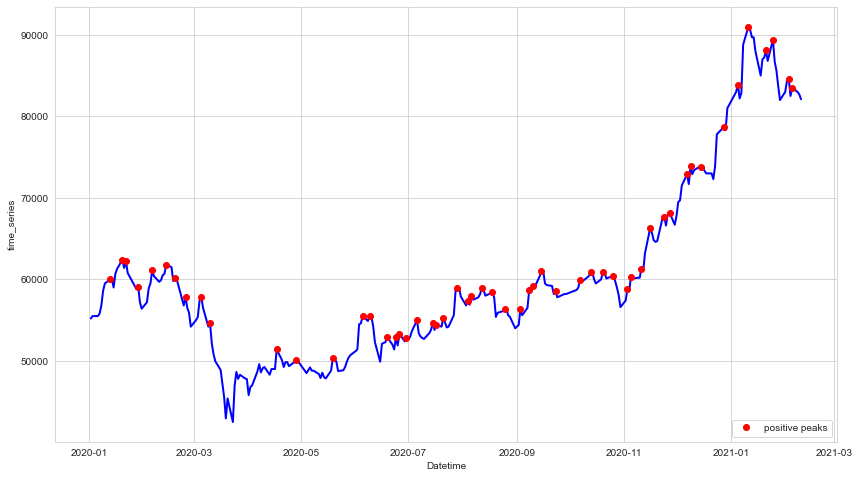

In [7]:
plt.figure(figsize = (14, 8))
plt.plot_date(time_series.index, time_series, 'b-', linewidth = 2)
plt.plot_date(time_series.index[peaks], time_series[peaks], 'ro', label = 'positive peaks')

plt.xlabel('Datetime')
plt.ylabel('time_series')
plt.legend(loc = 4)
plt.show()

### peak 일에 해당하는 뉴스 기사 확인

In [8]:
from bs4 import BeautifulSoup
import requests

from selenium import webdriver
from selenium.webdriver.chrome.options import Options

#뉴스 데이터 가져오기(관련기사는 제거)
def getPageNewsData(page) :
    url = news_url + "&page=" + str(page)
    response = requests.get(url)
    response.encoding = 'euc-kr' #한글깨짐방지
    soup = BeautifulSoup(response.text, 'html.parser')
    
    table = soup.find('table')
    rlist = table.find_all('tr', class_="relation_lst")
    for tr in rlist :
        tr.decompose()

    df = pd.read_html(str(table), header=0)[0].dropna()
    return df

#마지막 페이지 번호
def getLastPageNum(soup) :
    return int(soup.find("table", class_="Nnavi").find("td", class_="pgRR").find("a").get("href").split("&")[1].split("=")[1])

In [31]:
code = '005930'
news_url = 'https://finance.naver.com/item/news_news.nhn?code='+code
startDate = '2020.10.24'

#기사 가져오기
response = requests.get(news_url)
soup = BeautifulSoup(response.text, 'html.parser')

#마지막 페이지 가져오기
last_page = getLastPageNum(soup)

#페이지별로 loop 돌면서 dataframe으로 만들기
last_index = last_page+1

news_df = getPageNewsData(1).dropna()
for i in range(2, last_index) :
    tmp_df = getPageNewsData(i)
    add_df = tmp_df[tmp_df['날짜'] > startDate]
    news_df = pd.concat([news_df, add_df], ignore_index=True)
    if len(add_df) < len(tmp_df) : 
        break
        
#추가 : 중복제거
news_df = news_df.drop_duplicates()

# 데이터셋으로 쓸 dataframe 만들기
# 날짜 / 제목 / updown
news_df['date'] = news_df['날짜'].str.split(' ').str[0]
pivot_df = news_df.drop(['정보제공', '날짜'], axis=1).rename({'제목':'subject'}, axis='columns')
pivot_df

,subject,date
0,지난해 4분기 美 시장서 애플·삼성만 성장세,2021.02.10
1,MSCI 지수 신규 편입·제외 종목 없어... 삼성전자 비중 소폭 하락,2021.02.10
2,"""삼성, 다른 OS 쓰지마""…구글 'OS 갑질' 6월까지 결론?",2021.02.10
3,"삼성전자 ""'갤럭시S21', 전작 대비 판매량 30% 증가""",2021.02.10
4,"애플, 작년에도 세계 반도체 구매 1위…삼성전자는 2위",2021.02.10
...,...,...
4005,[속보]이건희 삼성전자 회장 별세,2020.10.25
4006,"외국인, 3주 연속 '사자'…삼성전자 사고 SK하이닉스 팔고",2020.10.25
4007,"삼성·LG전자, 소비자 취향 반영한 라이프스타일 가전 확대",2020.10.24
4008,"美 ITC, 삼성·LG OLED 특허침해 조사 결정",2020.10.24


In [32]:
# 뉴스기사가 2020-10-24 부터 있다...ㅡㅡ
pivot_df['Date'] = pd.to_datetime(pivot_df['date'])
pivot_df.drop(['date'], inplace=True, axis=1)
pivot_df

,subject,Date
0,지난해 4분기 美 시장서 애플·삼성만 성장세,2021-02-10
1,MSCI 지수 신규 편입·제외 종목 없어... 삼성전자 비중 소폭 하락,2021-02-10
2,"""삼성, 다른 OS 쓰지마""…구글 'OS 갑질' 6월까지 결론?",2021-02-10
3,"삼성전자 ""'갤럭시S21', 전작 대비 판매량 30% 증가""",2021-02-10
4,"애플, 작년에도 세계 반도체 구매 1위…삼성전자는 2위",2021-02-10
...,...,...
4005,[속보]이건희 삼성전자 회장 별세,2020-10-25
4006,"외국인, 3주 연속 '사자'…삼성전자 사고 SK하이닉스 팔고",2020-10-25
4007,"삼성·LG전자, 소비자 취향 반영한 라이프스타일 가전 확대",2020-10-24
4008,"美 ITC, 삼성·LG OLED 특허침해 조사 결정",2020-10-24


In [33]:
date_count = pivot_df.groupby('Date').count()
date_count

,subject
Date,
2020-10-24,3
2020-10-25,123
2020-10-26,79
2020-10-27,39
2020-10-28,26
...,...
2021-02-06,6
2021-02-07,13
2021-02-08,19


In [34]:
peak_list = [
    '2020-10-26', 
    '2020-11-03', '2020-11-05','2020-11-11', '2020-11-16', '2020-11-24', '2020-11-27',
    '2020-12-07', '2020-12-09', '2020-12-15', '2020-12-28',
    '2021-01-05', '2021-01-11', '2021-01-21', '2021-01-25',
    '2021-02-03', '2021-02-05']

In [39]:
# peak 일과 일치하지 않는다..
date_count_sorted = date_count.sort_values(by='subject', ascending=False)
date_count_sorted.head(30)

,subject
Date,
2020-10-29,190
2021-01-28,166
2020-10-25,123
2021-01-18,106
2020-12-02,98
2021-01-08,92
2021-01-19,83
2020-10-26,79
2020-12-04,68


In [44]:
def graph(df, cols, axv_list=[]) :
    rcParams['figure.figsize'] = 11.7,8.27
    ax = sns.lineplot(data=df[cols])
    
    plt.title('compare : ' + (', '.join(cols)), fontsize=20)
    plt.ylabel('Value', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.legend(fontsize=12, loc='best')
    
    if axv_list != [] :
        for i in axv_list :
            if len(i) == 4 :
                color = i[3]
            else :
                color = 'b'
            plt.axvline(x=datetime(i[0], i[1], i[2]), color=color, linestyle='--', linewidth=1)

    plt.show()
    return

def scale(df, method='minmax') :
    min_max_scaler = MinMaxScaler()
    fitted = min_max_scaler.fit(df)
    output = min_max_scaler.transform(df)
    output = pd.DataFrame(output, columns=df.columns, index=list(df.index.values))
    return output

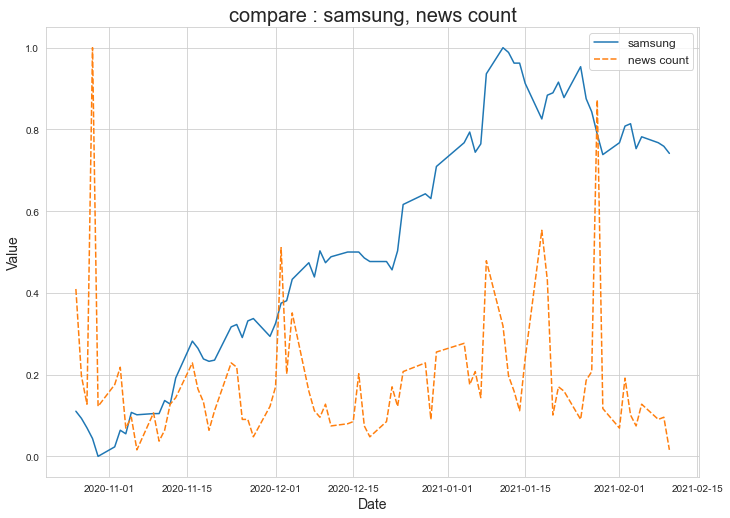

In [51]:
# 뉴스기사 건수와 samsung 주가 그래프로 비교해보기
samsung_scaled = scale(samsung['2020-10-24':][['Close']])
date_count_sorted_scaled = scale(date_count_sorted)

compare = pd.DataFrame(index=samsung_scaled.index)
compare['samsung'] = samsung_scaled
compare['news count'] = date_count_sorted_scaled
compare.dropna(inplace=True, axis=0)

graph(compare, compare.columns.tolist())

In [30]:
# 피크일에 나온 뉴스기사 제목 출력
for i in peak_list :
    print(i)
    print(pivot_df[i])
    print()

2020-10-26
                                               subject
Date                                                  
2020-10-26  서정진 셀트리온 회장 "이건희 회장, 삼성 세계적 기업 만든 제 2의 ...
2020-10-26             [이건희 별세] 삼성 사장단, 조문 행렬…눈시울 붉히기도
2020-10-26  일찍부터 빈소 찾은 삼성 사장단 "애통하다" [이건희 별세 줄잇는 추모...
2020-10-26           이재용시대 삼성의 중국전략은?…"가전 접고, 첨단산업 확대"
2020-10-26                 배당 기대에 주가 올랐지만…삼성 경영권 위협 노출
...                                                ...
2020-10-26       삼성전자 배당 추가증가 가능성, 동종업계 중 현금자산 최다-KTB證
2020-10-26          "회사 잘 지키겠습니다" 삼성 직원이 올린 이건희 회장 추모글
2020-10-26  '벌판에 홀로 선 이재용, 삼성그룹 어떻게 이끌까'… 저수익사업 정리할...
2020-10-26         '세계의 삼성' 그뒤엔 남보다 5년 멀리 봤던 '이건희의 혜안'
2020-10-26          '반도체 이건희'처럼 '이재용 시대' 정의할 삼성 신성장동력은

[81 rows x 1 columns]

2020-11-03
                                               subject
Date                                                  
2020-11-03           '미스터 LCD' 이상완 전 삼성전자 사장 별세…향년 70세
2020-11-03              지배구조 변경 앞두고 관망… 삼성그룹주 펀드 자금 이탈
2020-11-03  삼성전자 노사